<a href="https://www.kaggle.com/code/mehmetbakideniz/customer-segmentation-kprototype-shapley?scriptVersionId=127110673" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [38]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [39]:
!pip install kmodes
!pip install catboost


In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
import shap
import seaborn as sns

In [41]:
df = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv",sep="\t")
pd.set_option('display.max_columns', None)

In [42]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Feature Engineering¶
# 

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [44]:
# income is the only column with null values.  I delete those rows with null values
df = df.dropna(subset=['Income']).reset_index(drop=True) 

below I

1) combine binary variables in columns 20-24+28 into one column since they all point to the same question: whether the customer responded positively to a campaign by making a purchase

2) creat a new column age and enrollment_time and deleting year_birth and Dt_customer columns

3) create livingwith column that simplifies marital status column by assinging 1 to together and 0 to single status.

4) create children column that combines kidhome and teenhome columns.

5) simplify the education column by giving undergraduate degrees 0, graduate 1 and postgraduate 2




In [45]:
# renaming the response column as 6'th acceptedcmp because it shows whether the customer responded positively to the last campaing
df = df.rename(columns={'Response': 'AcceptedCmp6'})

df['Camp_responses']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['AcceptedCmp6']
campaign_dict = {'AcceptedCmp1': 1, 'AcceptedCmp2': 2, 'AcceptedCmp3': 3,
                 'AcceptedCmp4': 4, 'AcceptedCmp5': 5, 'AcceptedCmp6': 6}

df.drop(columns=campaign_dict.keys(), inplace=True)

# calculate age based on Year_Birth
current_year = dt.datetime.now().year
df['Age'] = current_year - df['Year_Birth']

# convert 'Dt_Customer' to datetime format and calculate enrollment time as number of months
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Enrollment_time'] = ((dt.datetime.now() - df['Dt_Customer']).dt.days / 12).round(1)

# drop the original columns
df.drop(columns=['Year_Birth', 'Dt_Customer'], inplace=True)

df["Living_With"]=df["Marital_Status"].replace({"Married":"1", "Together":"1", "Absurd":"0", "Widow":"0", "YOLO":"0", "Divorced":"0", "Single":"0",})

## To get a more clarity about family's background
df["Children"]=df["Kidhome"]+df["Teenhome"]
df.drop(columns=['Marital_Status', 'Kidhome', 'Teenhome'], inplace=True)


#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"0","2n Cycle":"0", "Graduation":"1", "Master":"2", "PhD":"2"})

# delete the redundant ID column
df.drop(columns=['ID'], inplace=True)



In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Recency              2216 non-null   int64  
 3   MntWines             2216 non-null   int64  
 4   MntFruits            2216 non-null   int64  
 5   MntMeatProducts      2216 non-null   int64  
 6   MntFishProducts      2216 non-null   int64  
 7   MntSweetProducts     2216 non-null   int64  
 8   MntGoldProds         2216 non-null   int64  
 9   NumDealsPurchases    2216 non-null   int64  
 10  NumWebPurchases      2216 non-null   int64  
 11  NumCatalogPurchases  2216 non-null   int64  
 12  NumStorePurchases    2216 non-null   int64  
 13  NumWebVisitsMonth    2216 non-null   int64  
 14  Complain             2216 non-null   int64  
 15  Z_CostContact        2216 non-null   i

some of these columns are indeed categorical such as education(3 values), Camp_reponses(6  values), children(3 values), complain(binary) and living with(binary).That is why, I convert these variables into type 'string'.  But why not use some sort of labeling or encoding and feed them into a clustering algorithm such as Kmeans? 

Traditional clustering algoritms such as dbscan, kmeans and hierarchical clustering are based on numeral distance and are known to be not working for non-continuous [variables](https://ijseas.com/volume2/v2i2/ijseas20160238.pdf). That's why, I would have to use K-mode clustering for categorical values and k-means for continous variables. Luckily, [kprototype](https://www.sciencedirect.com/science/article/abs/pii/S0925231213004773) uses both of those methods for mixed type datasets such as this dataset. 



In [47]:
df['Education'] = df['Education'].astype('string')
df['Living_With'] = df['Living_With'].astype('string')
# df['Children'] = df['Children'].astype('string')
# df['Camp_reponses'] = df['Camp_responses'].astype('string')
df['Complain'] = df['Complain'].astype('string')

# ALL COlumns need to be either integer or string for some of the models I will call below. 
df['Enrollment_time'] = df['Enrollment_time'].astype('int')
df['Income'] = df['Income'].astype('int')


OUTLIER DETECTION

Starting with whiskers plot of each integer variables is a good idea to detect outliers 

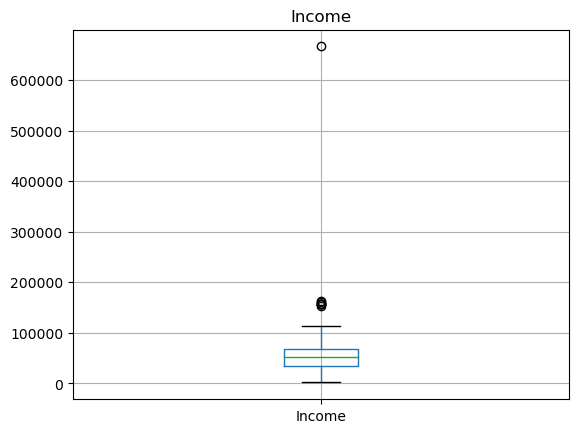

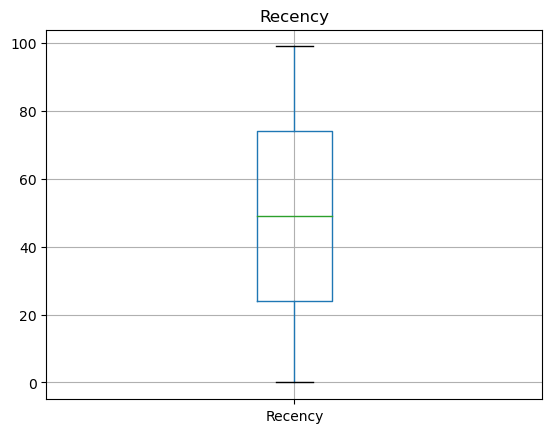

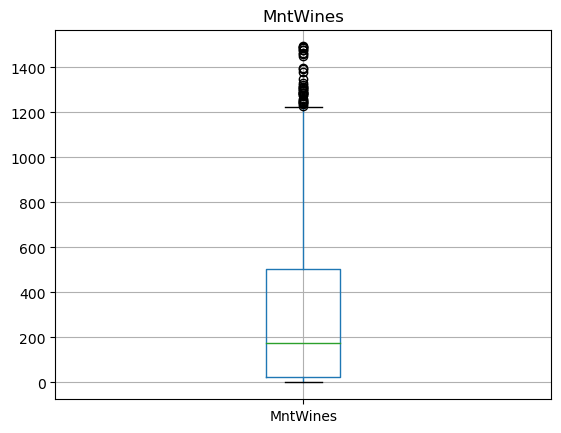

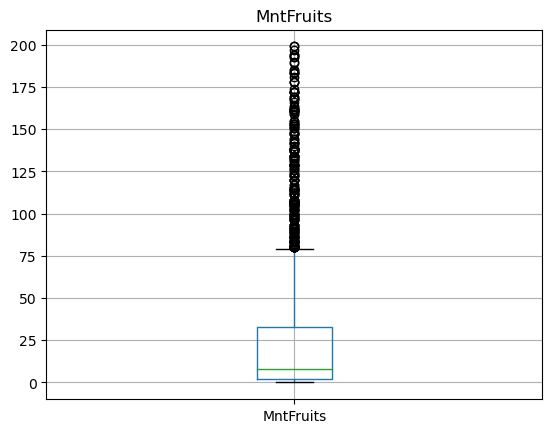

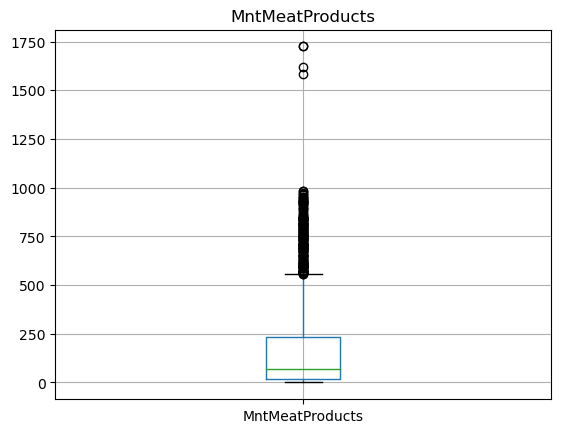

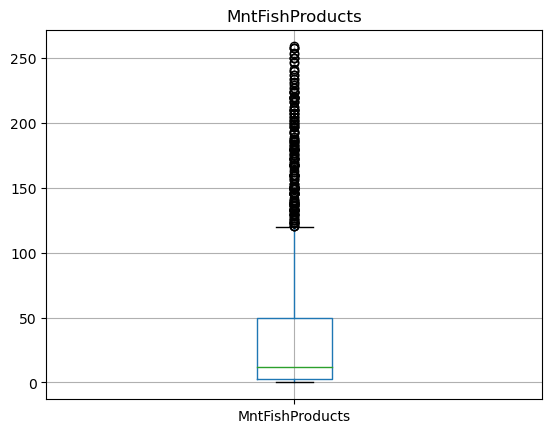

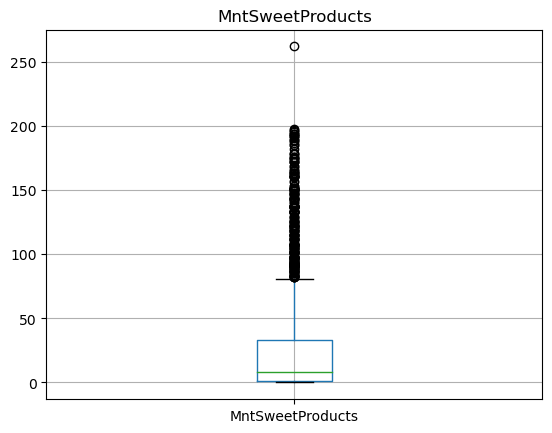

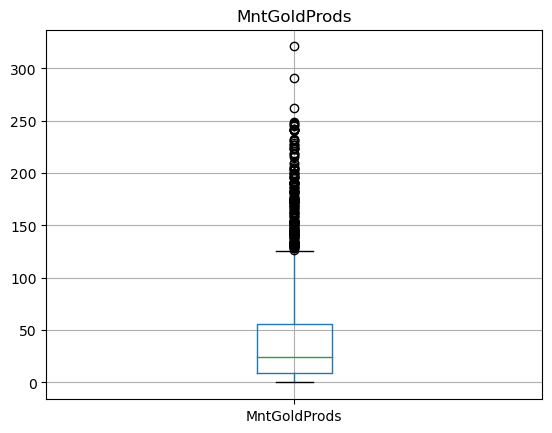

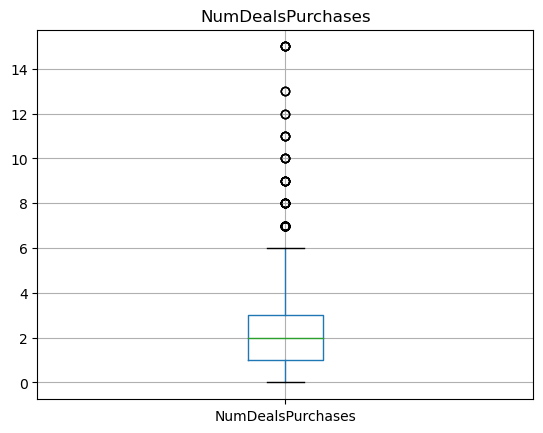

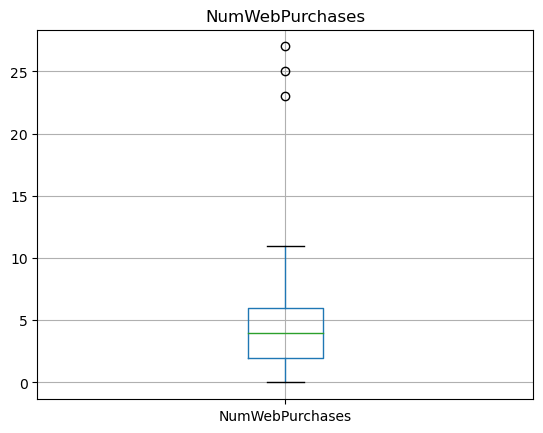

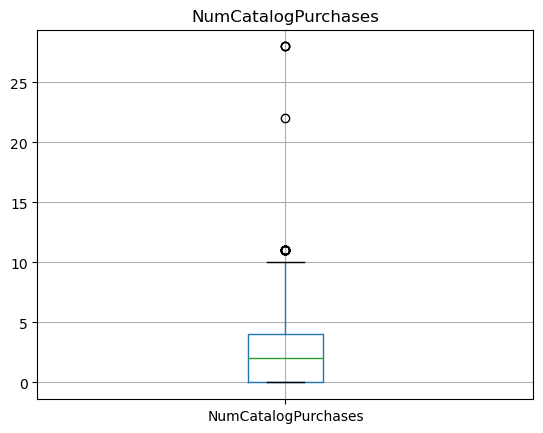

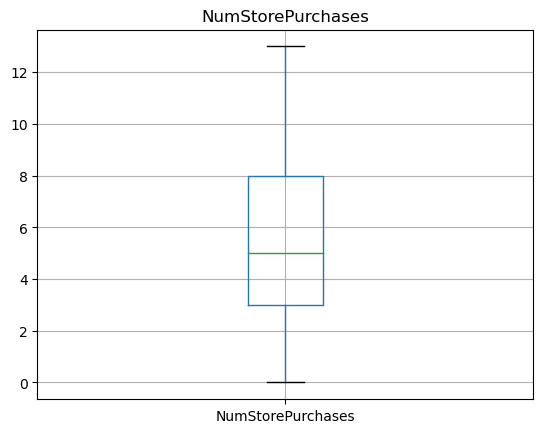

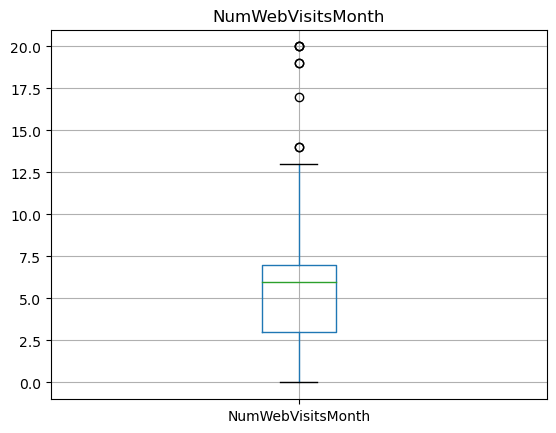

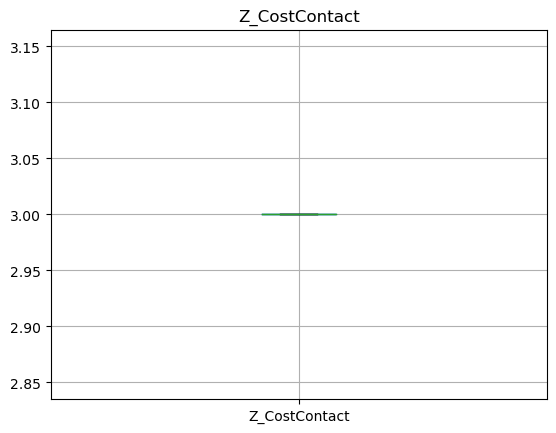

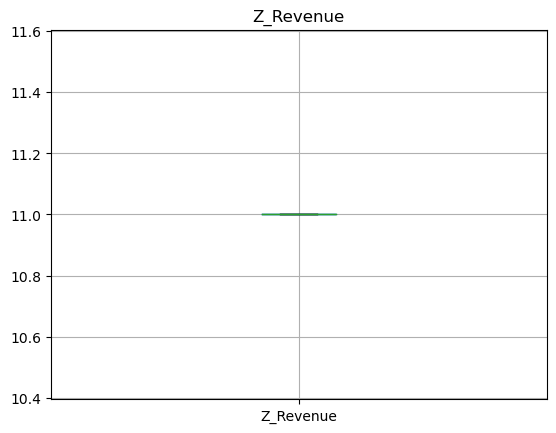

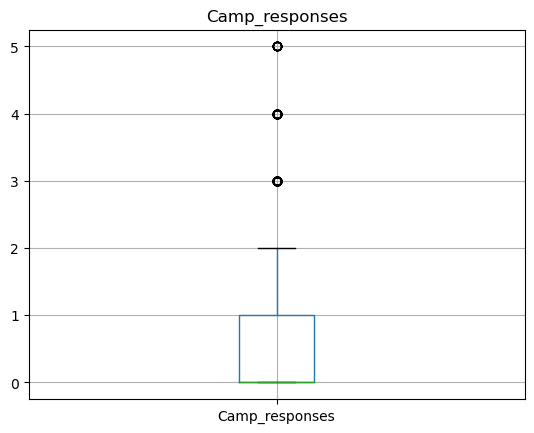

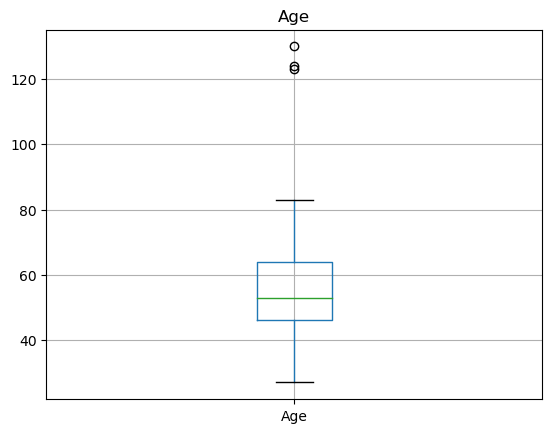

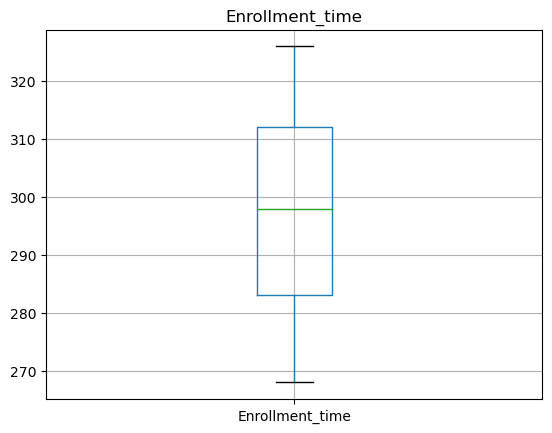

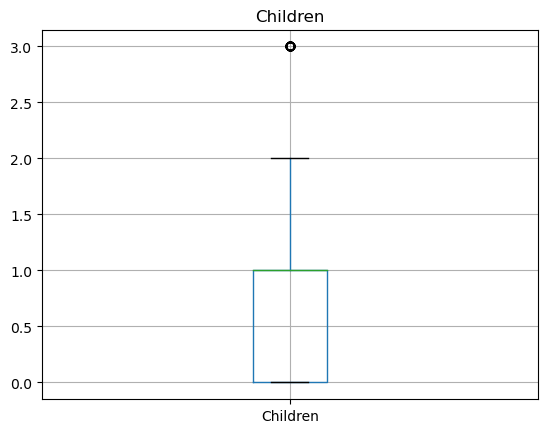

In [48]:
# Filter out string columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Create box plots for each numeric column
for col in numeric_cols:
    df[[col]].boxplot()
    plt.title(col)
    plt.show()


most of the columns have outliers as you can observe on the box plot. I delete outliers using box plot formula.

In [49]:
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    a = q1 - 1.5 * iqr
    b = q3 + 1.5 * iqr
    outliers = df[(df[col] < a) | (df[col] > b)]
    outlier_index = outliers.index
    df.drop(outlier_index, inplace=True)
df = df.reset_index(drop=True)

now we have one third of the rows in the original dataset.

In [50]:
df.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Camp_responses,Age,Enrollment_time,Children
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.00000,837.000000,837.0,837.0,837.0,837.000000,837.000000,837.000000
mean,34771.143369,51.028674,41.080048,4.286738,20.982079,6.048984,4.000000,12.357228,1.988053,2.097969,0.440860,3.23417,6.344086,3.0,11.0,0.0,51.997611,294.032258,1.273596
std,12024.378774,28.805056,54.287662,6.225160,22.676230,7.469955,4.951197,12.388652,1.162554,1.345721,0.607295,0.82144,1.601772,0.0,0.0,0.0,11.057483,16.187379,0.697180
min,7500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.00000,1.000000,3.0,11.0,0.0,28.000000,268.000000,0.000000
25%,26091.000000,26.000000,8.000000,0.000000,7.000000,0.000000,0.000000,4.000000,1.000000,1.000000,0.000000,3.00000,5.000000,3.0,11.0,0.0,44.000000,279.000000,1.000000
50%,34421.000000,51.000000,20.000000,2.000000,14.000000,3.000000,2.000000,8.000000,2.000000,2.000000,0.000000,3.00000,7.000000,3.0,11.0,0.0,51.000000,293.000000,1.000000
75%,42997.000000,77.000000,50.000000,6.000000,25.000000,8.000000,6.000000,17.000000,3.000000,3.000000,1.000000,4.00000,8.000000,3.0,11.0,0.0,60.000000,307.000000,2.000000
max,69139.000000,99.000000,365.000000,51.000000,206.000000,47.000000,25.000000,66.000000,6.000000,8.000000,2.000000,5.00000,10.000000,3.0,11.0,0.0,83.000000,326.000000,3.000000


In [51]:
# deleting the z_costcontact and Z_revenue columns as they have zero variation and therefore no use for clustering purposes 
df = df.drop(columns=['Z_CostContact', 'Z_Revenue'])


In [52]:
df.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Camp_responses,Age,Enrollment_time,Living_With,Children
0,1,46344,38,11,1,6,2,1,6,2,1,1,2,5,0,0,69,277,0,2
1,1,26646,26,11,4,20,10,3,5,2,2,0,4,6,0,0,39,280,1,1
2,2,33454,32,76,10,56,3,1,23,2,4,0,4,8,0,0,38,303,1,1
3,0,7500,59,6,16,11,11,1,16,1,2,0,3,8,0,0,47,317,1,0
4,2,59354,53,233,2,53,3,5,14,3,6,1,5,6,0,0,71,287,0,2


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education            837 non-null    string
 1   Income               837 non-null    int64 
 2   Recency              837 non-null    int64 
 3   MntWines             837 non-null    int64 
 4   MntFruits            837 non-null    int64 
 5   MntMeatProducts      837 non-null    int64 
 6   MntFishProducts      837 non-null    int64 
 7   MntSweetProducts     837 non-null    int64 
 8   MntGoldProds         837 non-null    int64 
 9   NumDealsPurchases    837 non-null    int64 
 10  NumWebPurchases      837 non-null    int64 
 11  NumCatalogPurchases  837 non-null    int64 
 12  NumStorePurchases    837 non-null    int64 
 13  NumWebVisitsMonth    837 non-null    int64 
 14  Complain             837 non-null    string
 15  Camp_responses       837 non-null    int64 
 16  Age     

In [54]:
# select columns with data type 'string'
object_cols = df.select_dtypes(include=['string']).columns

# get the index of the object columns
object_cols_index = object_cols.to_list()

object_cols_index = [df.columns.get_loc(col) for col in object_cols]


print(object_cols_index)  


[0, 14, 18]


In [55]:
df_scaled=df.copy()
# select only the non-object columns
non_obj_cols = df_scaled.select_dtypes(exclude=['string']).columns

# apply robust standization to the non-object columns 
scaler = RobustScaler()
df_scaled[non_obj_cols] = scaler.fit_transform(df_scaled[non_obj_cols])


df_scaled.describe().round()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Camp_responses,Age,Enrollment_time,Children
count,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0
mean,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
min,-2.0,-1.0,-0.0,-0.0,-1.0,-0.0,-0.0,-1.0,-0.0,-1.0,0.0,-1.0,-2.0,0.0,-1.0,-1.0,-1.0
25%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-1.0,0.0,-0.0,-0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
max,2.0,1.0,8.0,8.0,11.0,6.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,0.0,2.0,1.0,2.0


Applying the elbow method to find the optimal cluster number.

In [56]:
cost = []
for num_clusters in list(range(1,8)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(df_scaled, categorical=object_cols_index)
    cost.append(kproto.cost_)




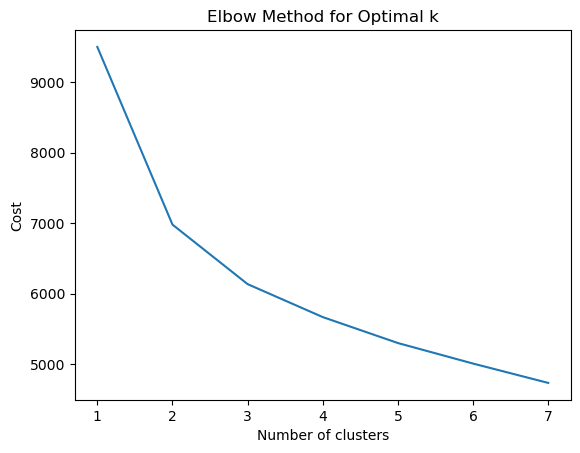

In [57]:
plt.plot(range(1, 8), cost)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

K=3 seems like a good choice. so lets re-train with k=3 this time with more initializations.

In [58]:
    kproto = KPrototypes(n_clusters=3, init='Cao', n_init=100)
    kproto.fit_predict(df_scaled, categorical=object_cols_index)


array([2, 2, 0, 1, 0, 1, 2, 1, 1, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1,
       2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 2, 0, 1, 1, 2, 2,
       2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 0,
       2, 2, 1, 0, 2, 1, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2, 2, 1, 0, 2, 0, 2,
       2, 0, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       1, 2, 2, 1, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 2,
       2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1,


SHAPLEY VALUE ANALYSIS OF CLUSTERS

I will analyse shapley values to understand which features are most important for each cluster. For this purpose
I add the cluster values to the original DF and will apply Catboost to now labeled dataset to understand feature importance through SHAPLEY values. Such an analysis helps with cluster analysis for datasets with high dimensions. 

In [59]:
df['cluster']=kproto.labels_
df.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Camp_responses,Age,Enrollment_time,Living_With,Children,cluster
0,1,46344,38,11,1,6,2,1,6,2,1,1,2,5,0,0,69,277,0,2,2
1,1,26646,26,11,4,20,10,3,5,2,2,0,4,6,0,0,39,280,1,1,2
2,2,33454,32,76,10,56,3,1,23,2,4,0,4,8,0,0,38,303,1,1,0
3,0,7500,59,6,16,11,11,1,16,1,2,0,3,8,0,0,47,317,1,0,1
4,2,59354,53,233,2,53,3,5,14,3,6,1,5,6,0,0,71,287,0,2,0


there is no need for train test split and worry about overfitting because we won't use the model for prediction purposes but to explore which features are important for each of the three clusters. So I first train a 
catboost model becuase the datasets contains a mixture of categorical and numerical variables. I will then analyze feature importance for each cluster through SHAP values. 

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education            837 non-null    string
 1   Income               837 non-null    int64 
 2   Recency              837 non-null    int64 
 3   MntWines             837 non-null    int64 
 4   MntFruits            837 non-null    int64 
 5   MntMeatProducts      837 non-null    int64 
 6   MntFishProducts      837 non-null    int64 
 7   MntSweetProducts     837 non-null    int64 
 8   MntGoldProds         837 non-null    int64 
 9   NumDealsPurchases    837 non-null    int64 
 10  NumWebPurchases      837 non-null    int64 
 11  NumCatalogPurchases  837 non-null    int64 
 12  NumStorePurchases    837 non-null    int64 
 13  NumWebVisitsMonth    837 non-null    int64 
 14  Complain             837 non-null    string
 15  Camp_responses       837 non-null    int64 
 16  Age     

In [61]:
# catboost requires the labels to be type integer
df['cluster'] = df['cluster'].astype('int')


In [62]:
X = df.drop('cluster', axis=1)
y = df['cluster']

catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function='MultiClass', eval_metric='Accuracy', random_seed=42)

catboost.fit(X, y, cat_features=object_cols_index)




0:	learn: 0.8578256	total: 6.88ms	remaining: 681ms
1:	learn: 0.9115890	total: 12.4ms	remaining: 606ms
2:	learn: 0.9366786	total: 16.8ms	remaining: 545ms
3:	learn: 0.9366786	total: 21.4ms	remaining: 515ms
4:	learn: 0.9522103	total: 27.8ms	remaining: 528ms
5:	learn: 0.9641577	total: 33.6ms	remaining: 526ms
6:	learn: 0.9569892	total: 37.7ms	remaining: 501ms
7:	learn: 0.9653524	total: 41.3ms	remaining: 475ms
8:	learn: 0.9617682	total: 45.2ms	remaining: 457ms
9:	learn: 0.9701314	total: 49.1ms	remaining: 442ms
10:	learn: 0.9665472	total: 53ms	remaining: 429ms
11:	learn: 0.9725209	total: 57.2ms	remaining: 419ms
12:	learn: 0.9725209	total: 61.1ms	remaining: 409ms
13:	learn: 0.9713262	total: 65ms	remaining: 399ms
14:	learn: 0.9689367	total: 68.8ms	remaining: 390ms
15:	learn: 0.9713262	total: 72.4ms	remaining: 380ms
16:	learn: 0.9689367	total: 75.9ms	remaining: 371ms
17:	learn: 0.9737157	total: 79.5ms	remaining: 362ms
18:	learn: 0.9701314	total: 82.9ms	remaining: 354ms
19:	learn: 0.9725209	total

In [63]:
explainer = shap.TreeExplainer(catboost, cat_features=object_cols_index)

# Computing SHAP values for the training data
shap_values = explainer(X).values


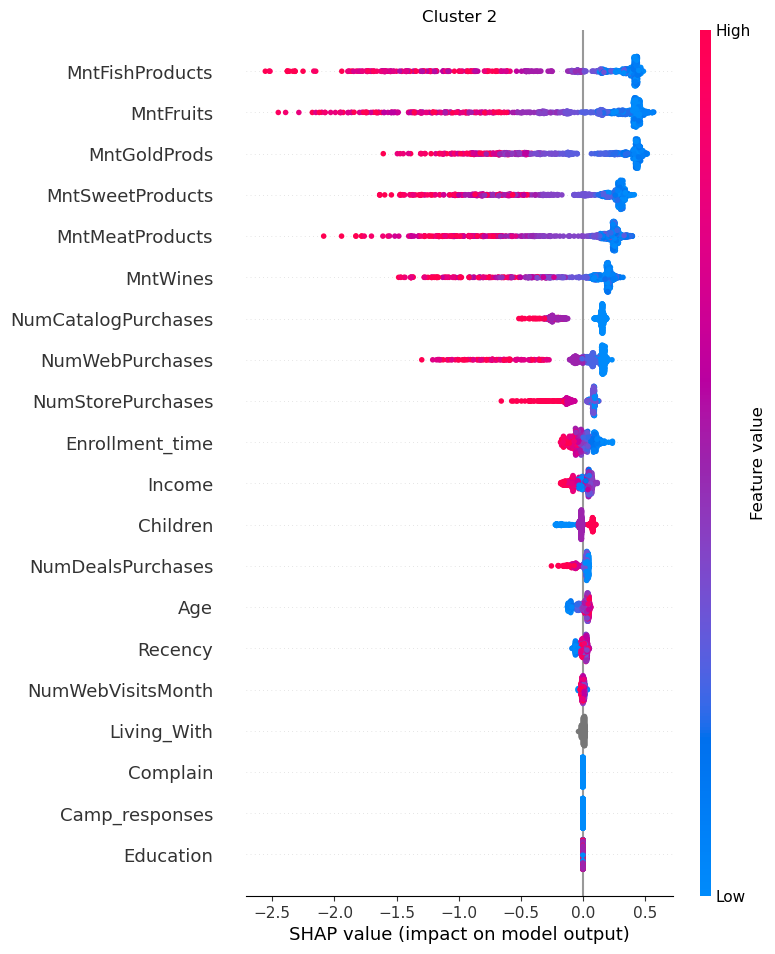

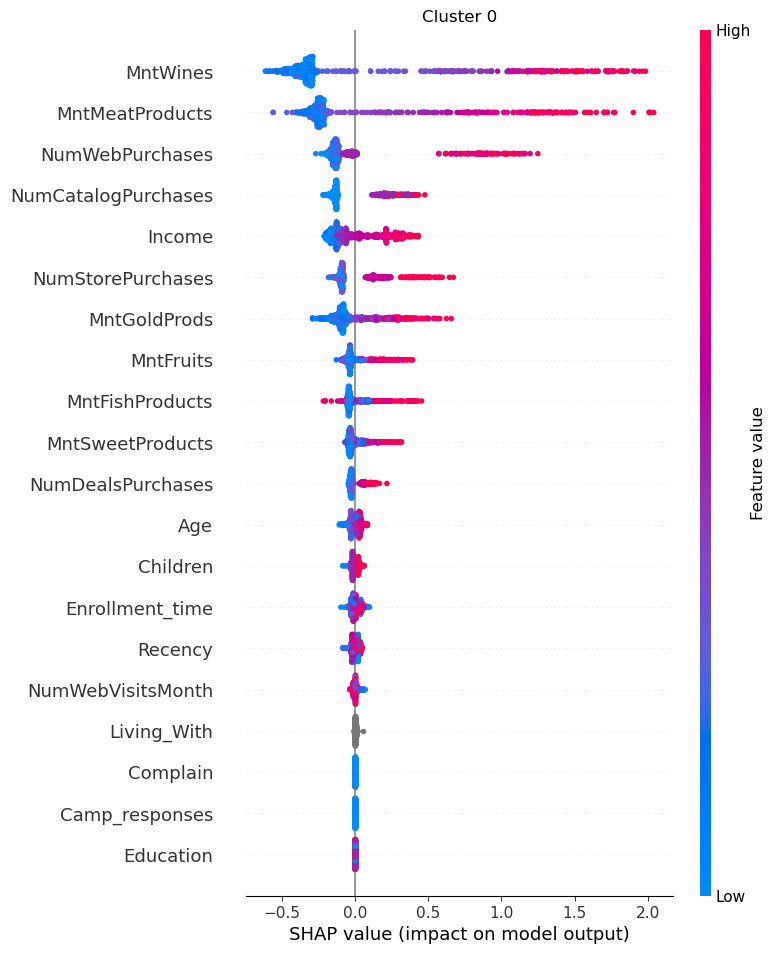

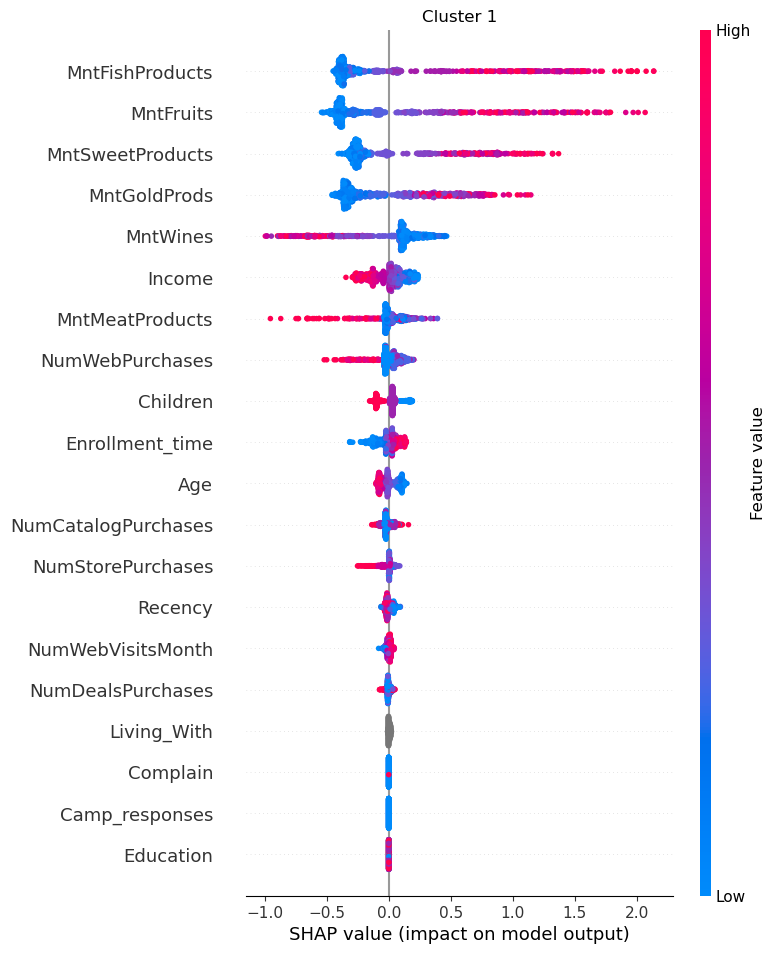

In [64]:
for cnr in df['cluster'].unique():
    shap.summary_plot(shap_values[:, :, cnr], X, max_display=30, show=False)
    plt.title(f'Cluster {cnr}')
    plt.show()

**how to interpret Shapley Values**

Shapley values provide feature importance for each label in the dataset. On the y axis, positive
Values refer high importance. The bigger the value on the y axis the bigger the importance of this feature on the specific cluster. A red color indicates high values for this feature. So red color on a positive Shapley value means high values of that feature means higher importance for the label. By the same token, red value on the negative axis indicates higher values cause negative importance for the feature.
 
**Cluster 2**


Cluster 2 is a ‘non spender’. They are most likely old people with low tendency to spend but spends some on meat and fish products. They are the cluster with high number of children. 

**Cluster 1**

It is a complete spender cluster with income having high importance. They spend on every item group but they prioritize meat, wine and gold. They are also deal lovers. They prefer web and store purchases over catalog purchases. They are younger than cluster 1 but older than cluster 0.
They have fewer children than cluster 1. We would expect them to have high income but this needs to be verified with further analysis
**Cluster 0** 
 
they are the youngest cluster. They dont have children.  While they don’t spend as much as cluster 1, they still spend in every item category. They are also the customer group with oldest enrollment.  Their income level is more significant than cluster 2, it is not as significant as cluster 1. 


Shapley analysis gives us a clue on which features are the most important for the making of clusters. But it doesnt tell us whether, for instance, any cluster group is defined by high income. Rather, it tells us that higher income values defines this cluster. That is to say, there can be another cluster with high income people yet it still can be an insignificant factor for this cluster. So we need to see the distribution of values for each feature that is important for the clusters. These are MntFishProducts,MntFruitProducts, MntGoldProducts, MntWineProducts,MntMeatProducts, Income, Age, Children. Below, I show box plot for each of these features. 

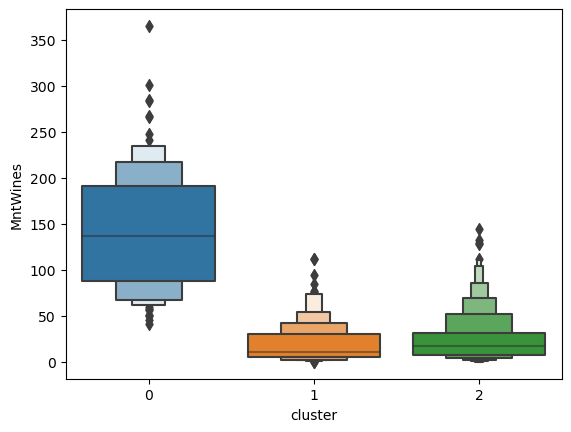

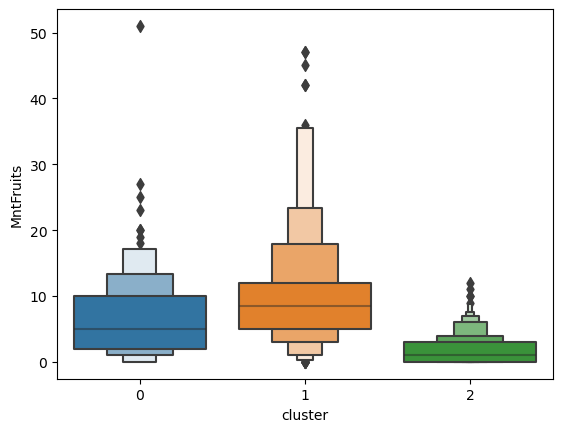

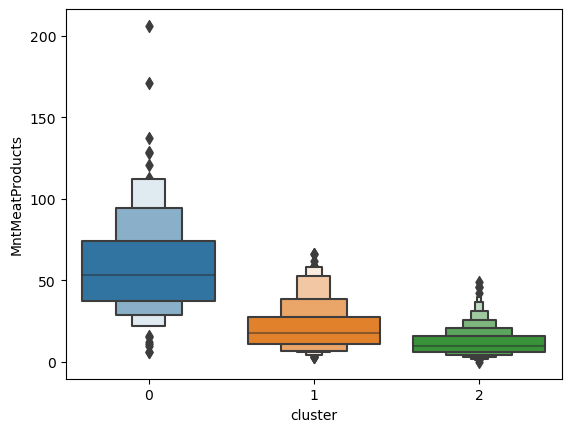

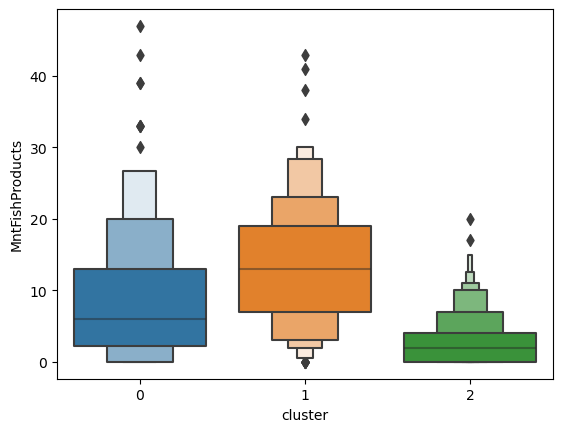

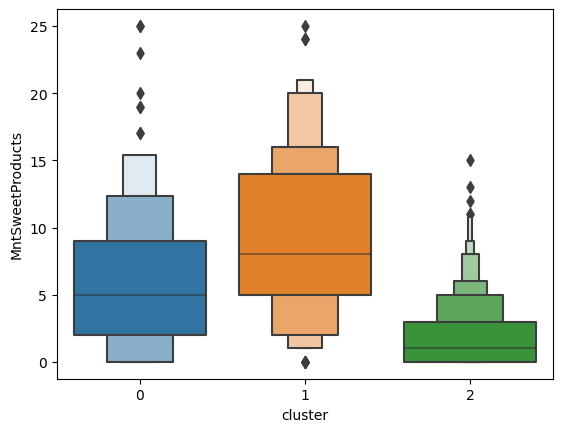

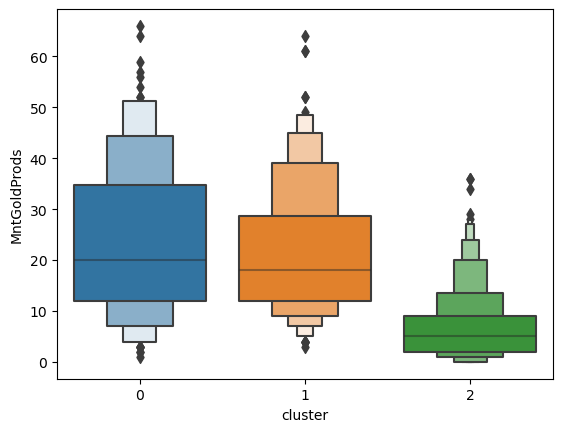

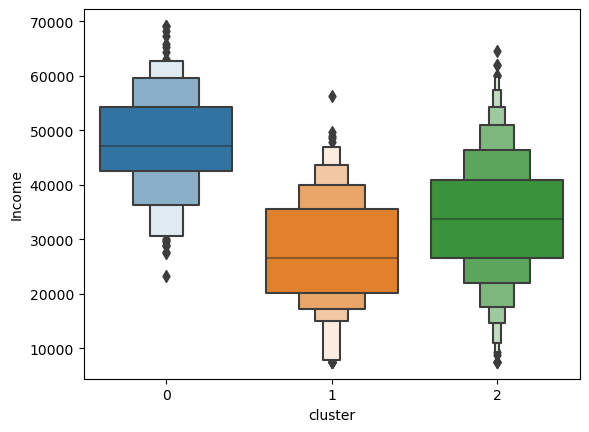

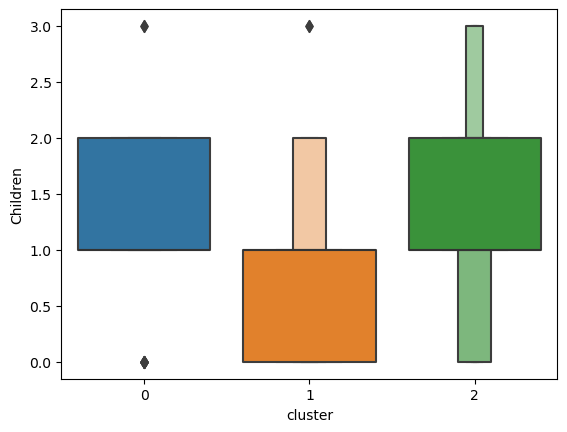

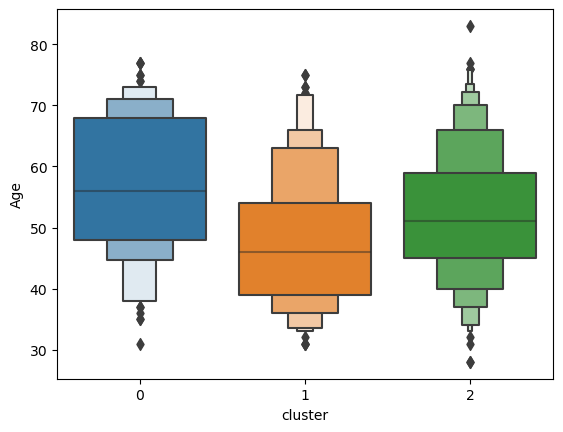

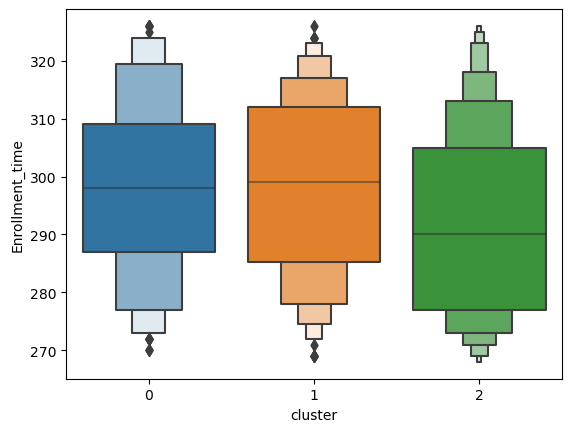

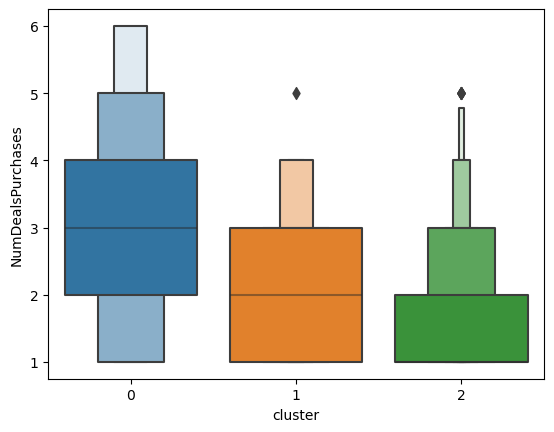

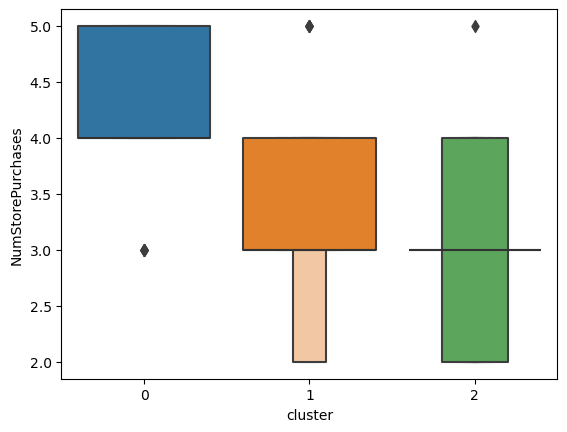

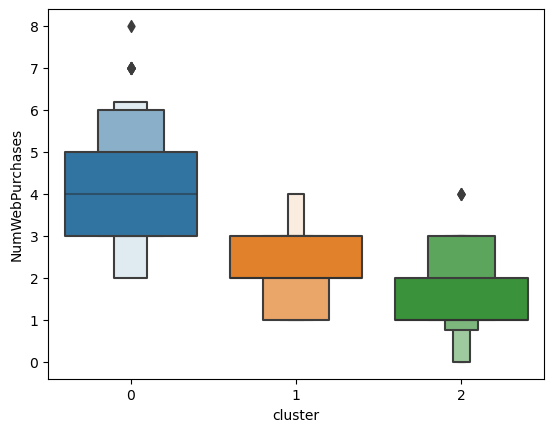

In [65]:
Product_vars = ['MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'Income', 'Children', 'Age', 'Enrollment_time', 'NumDealsPurchases', 'NumStorePurchases', 'NumWebPurchases']
for i in Product_vars:
    sns.boxenplot(x = 'cluster' , y =i ,data = df);
    plt.show()


The usefullness of box plots is that it allows one to quickly observe the central tendency in the datasets. the parallel line in each rectangle shows the median values for each feature. So I am using these values to gain more insights on the clusters. 


When we observe the graphs,  income is the most perplexing one. Group 0 has the highest amount of income with  48 as the meadian which is expected out of shapley values. While one would expect group 2 having lower income than 1, interestingly,  group 2, a non-spender has higher median income(35) than group 1 (25). 

Group 1 consumes wine the most. group 0 and 1 consumes fruit  
Group 0 consumes meat in disproportionate amounts compared with the two clusters

Group 1 is a lover of fish products while the two other clusters don’t spend that much

Despite income difference, group 1 and 0 consume in high amounts of gold with group 0  a little higher than group 1.

Age does not differentiate the clusters. They are around 50 years old. Group 0 is the only cluster with interest in deals. 

*So in summary*

**cluster 0**

It has the highest income. consumes meat and gold the most. It is the only group affected by deals.

**cluster 1**

is the group with the lowest income yet consumes  all products albeit lower than group 0. It is the only group that consumes wine in high amounts. 

**Cluster 3**

It is a non-spender. Yet its median income is only 10000 dollars short of group 0-our star customer group and higher than group 1- a definite spender. So a targeted focus on this group might help to realise their potential. 



